In [21]:
from __future__ import division
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (14,10)
import matplotlib.pyplot as plt
from scipy.signal import welch

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
end_idx=int(66800)
#hoft = np.loadtxt('../SGWB_withnoise_full.txt')
hoft = np.loadtxt('../noisless_mldc.txt')
times, hX, hY, hZ = hoft[0:end_idx, 0], hoft[0:end_idx, 1], hoft[0:end_idx, 2], hoft[0:end_idx, 3]

In [5]:
## PSD of the data
fs = 1.0/(times[1] - times[0])
fx, Sx = welch(hX,fs=fs, nperseg=int(1e4*fs) )
fx, Sx = fx[1:], Sx[1:]

In [13]:
## antenna pattern
Larm=2.5e9
cspeed=3e8
fstar = cspeed/(2*np.pi*Larm)



Fx, Fy, Fz = tdi_isgwb_xyz_response(0.5*fx/fstar)

In [14]:
## theoretical PSD
Na = (3.0e-15)**2 * (1 + (4e-4/fx)**2) *  (1  + (fx/8e-3)**4) *(1.0/(2*np.pi*fx))**4 * (2*np.pi*fx/cspeed)**2
Np = (15e-12)**2 * (1 + (2e-3/fx)**4) *(2*np.pi*fx/cspeed)**2

#Sx_instr = 2*16 * (np.sin(fx/fstar))**2 * (Np + 2 * Na * (np.sin(2*fx/fstar))**2 )

Sx_instr = 16.0 * np.sin(fx/fstar)**2 * (2.0 * (1.0 + np.cos(fx/fstar)**2) * Na + Np)

omega_f = 3.5e-9 * (fx/25)**0.667
H0 = 2.2*10**(-18)

Fx_prime = (2*np.sin(fx/fstar))**2 * 0.3 ## * 1/ (1 + 0.6* (fx/fstar)**2)


Sx_gw = omega_f * (3*H0**2)/(4 * np.pi**2 * fx**3) * Fx * (4*np.pi*fx*Larm/cspeed)**2
Sx_gw_prime = omega_f * (3*H0**2)/(4 * np.pi**2 * fx**3) * Fx_prime * (4*np.pi*fx*Larm/cspeed)**2


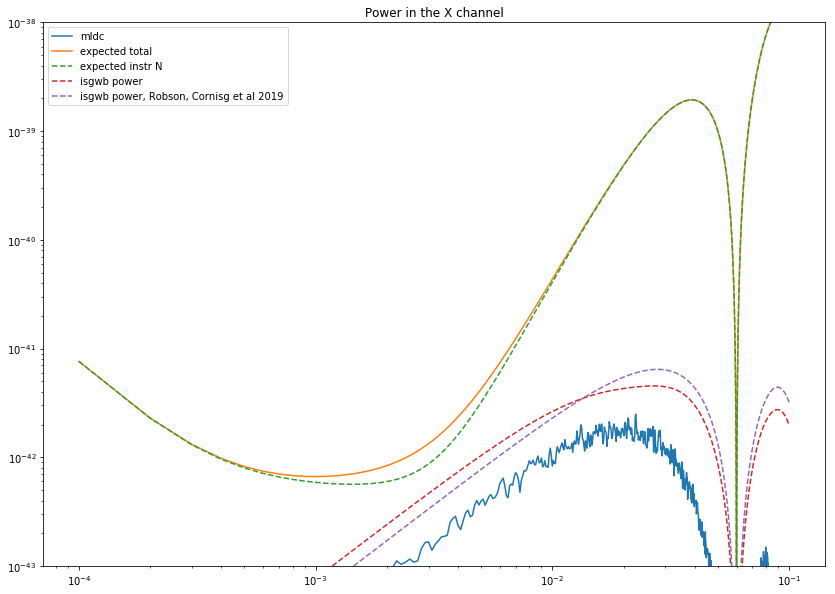

In [22]:
plt.loglog(fx, Sx, label='mldc')
plt.loglog(fx, Sx_instr + Sx_gw, label='expected total')
plt.loglog(fx, Sx_instr,'--' ,  label='expected instr N')
plt.loglog(fx, Sx_gw,'--' , label='isgwb power')
plt.loglog(fx, Sx_gw_prime,'--' , label='isgwb power, Robson, Cornisg et al 2019')
plt.title('Power in the X channel')
plt.ylim(1e-43, 1e-38)
plt.legend()

In [38]:
hA = (1.0/np.sqrt(6))*(hX - 2*hY + hZ)
fs = 1.0/(times[1] - times[0])
fA, SA = welch(hA,fs=fs, nperseg=int(1e4*fs) )
fA, SA = fA[1:], SA[1:]

In [39]:
FA, FE, FT = tdi_isgwb_response(0.5*fA/fstar)

In [40]:
SA_instr = (16.0/3.0) * ((np.sin(fA/fstar))**2) * Np*(np.cos(fA/fstar) + 2) \
            + (16.0/3.0) * ((np.sin(fA/fstar))**2) * Na*(4*np.cos(fA/fstar) + 2*np.cos(2*fA/fstar) + 6)

omega_f = 3.5e-9 * (fx/25)**0.667
H0 = 2.2*10**(-18)


SA_gw = omega_f * (3*H0**2)/(4 * np.pi**2 * fx**3) * FA * (4*np.pi*fx*Larm/cspeed)**2


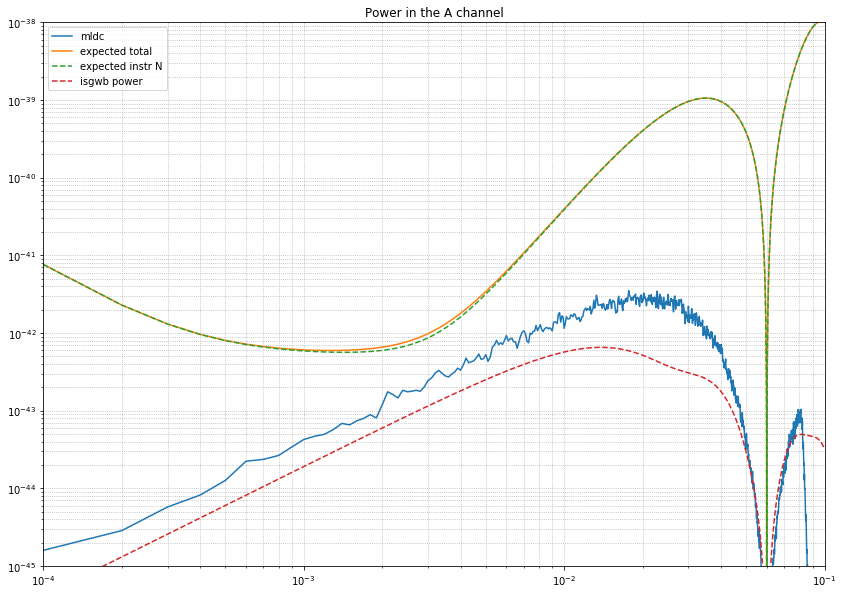

In [41]:
plt.loglog(fA, SA, label='mldc')
plt.loglog(fA, SA_instr + SA_gw, label='expected total')
plt.loglog(fA, SA_instr,'--' ,  label='expected instr N')
plt.loglog(fA, SA_gw,'--' , label='isgwb power')
plt.title('Power in the A channel')
plt.ylim(1e-45, 1e-38)
plt.xlim(1e-4, 1e-1)
plt.grid( linestyle=':', which='both')
plt.legend()

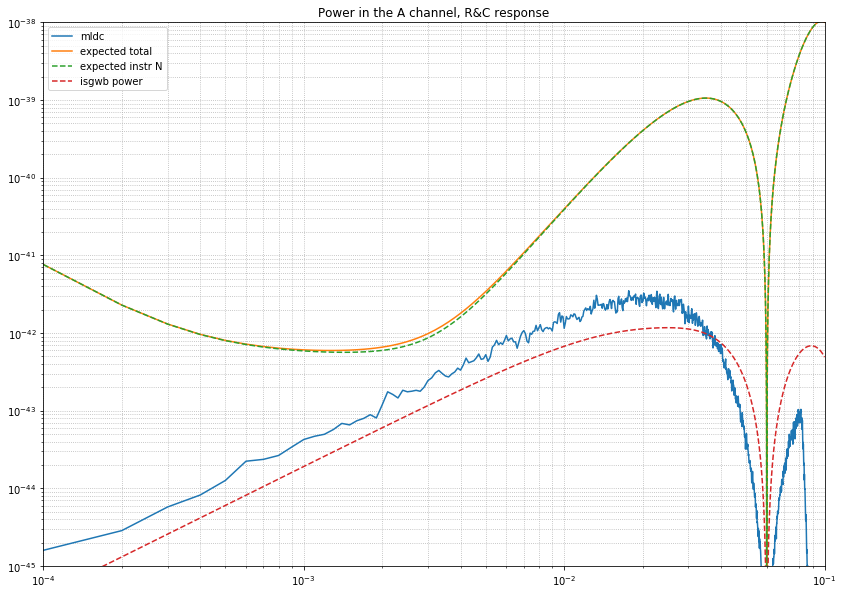

In [25]:
plt.loglog(fA, SA, label='mldc')
plt.loglog(fA, SA_instr + SA_gw, label='expected total')
plt.loglog(fA, SA_instr,'--' ,  label='expected instr N')
plt.loglog(fA, SA_gw,'--' , label='isgwb power')
plt.title('Power in the A channel, R&C response')
plt.ylim(1e-45, 1e-38)
plt.xlim(1e-4, 1e-1)
plt.grid( linestyle=':', which='both')
plt.legend()

In [20]:
np.log10(3.6e-49)

-48.44369749923271

In [36]:
def tdi_isgwb_response( f0): 

    '''
    Calcualte the Antenna pattern/ detector transfer function functions to an isotropic SGWB using A, E and T TDI channels. Note that since this is the response to an isotropic background, the response function is integrated over sky direction and averaged over polarozation. The angular integral is a linear and rectangular in the cos(theta) and phi space.  Note that f0 is (pi*L*f)/c and is input as an array

        

    Parameters
    -----------

    f0   : float
    A numpy array of scaled frequencies (see above for def)

    

    Returns
    ---------

    R1, R2 and R3   :   float
    Antenna Patterns for the given sky direction for the three channels, integrated over sky direction and averaged over polarization.
    '''

        
    tt = np.arange(-1, 1, 0.01)
    pp = np.arange(0, 2*np.pi, np.pi/100)

    [ct, phi] = np.meshgrid(tt,pp)
    dct = ct[0, 1] - ct[0,0]
    dphi = phi[1,0] - phi[0,0]

    ## udir is just u.r, where r is the directional vector
    udir = np.sqrt(1-ct**2) * np.sin(phi + np.pi/6)
    vdir = np.sqrt(1-ct**2) * np.sin(phi - np.pi/6)
    wdir = vdir - udir

    # Initlize arrays for the detector reponse
    R1 = np.zeros(f0.size)
    R2 = np.zeros(f0.size)
    R3 = np.zeros(f0.size)

    # Calculate the detector response for each frequency
    for ii in range(0, f0.size):

        # Calculate GW transfer function for the michelson channels
        gammaU    =    1/2 * (np.sinc((f0[ii])*(1 - udir))*np.exp(-1j*f0[ii]*(3+udir)) + \
                         np.sinc((f0[ii])*(1 + udir))*np.exp(-1j*f0[ii]*(1+udir)))

        gammaV    =    1/2 * (np.sinc((f0[ii])*(1 - vdir))*np.exp(-1j*f0[ii]*(3+vdir)) + \
                         np.sinc((f0[ii])*(1 + vdir))*np.exp(-1j*f0[ii]*(1+vdir)))

        gammaW    =    1/2 * (np.sinc((f0[ii])*(1 - wdir))*np.exp(-1j*f0[ii]*(3+wdir)) + \
                         np.sinc((f0[ii])*(1 + wdir))*np.exp(-1j*f0[ii]*(1+wdir)))

        ## Michelson Channel Antenna patterns for + pol
        ##  Fplus_u = 1/2(u x u)Gamma(udir, f):eplus

        Fplus_u   = 1/2*(1/4*(1-ct**2) + 1/2*(ct**2)*(np.cos(phi))**2 - np.sqrt(3/16)*np.sin(2*phi)*(1+ct**2) + \
                        0.5*((np.cos(phi))**2 - ct**2))*gammaU

        Fplus_v   = 1/2*(1/4*(1-ct**2) + 1/2*(ct**2)*(np.cos(phi))**2 + np.sqrt(3/16)*np.sin(2*phi)*(1+ct**2) + \
                         0.5*((np.cos(phi))**2 - ct**2))*gammaV

        Fplus_w   = 1/2*(1 - (1+ct**2)*(np.cos(phi))**2)*gammaW


        ## Michelson Channel Antenna patterns for x pol
        ##  Fcross_u = 1/2(u x u)Gamma(udir, f):ecross
        Fcross_u  = - np.sqrt(1-ct**2)/2 * (np.sin(2*phi + np.pi/3))*gammaU
        Fcross_v  = - np.sqrt(1-ct**2)/2 * (np.sin(2*phi - np.pi/3))*gammaV
        Fcross_w   = 1/2*ct*np.sin(2*phi)*gammaW


        ## First Michelson antenna patterns
        ## Calculate Fplus
        Fplus1 = (Fplus_u - Fplus_v)
        Fplus2 = (Fplus_w - Fplus_u)
        Fplus3 = (Fplus_v - Fplus_w)

        ## Calculate Fcross
        Fcross1 = (Fcross_u - Fcross_v)
        Fcross2 = (Fcross_w - Fcross_u)
        Fcross3 = (Fcross_v - Fcross_w)

        ## Calculate antenna patterns for the A, E and T channels -  We are switiching to doppler channel.
        FAplus = (1/3)*np.sin(2*f0[ii])*(2*Fplus1 - Fplus2 - Fplus3)
        FEplus = (1/np.sqrt(3))*np.sin(2*f0[ii])*(Fplus3 - Fplus2)
        FTplus = (1/3)*np.sin(2*f0[ii])*(Fplus1 + Fplus3 + Fplus2)

        FAcross = (1/3)*np.sin(2*f0[ii])*(2*Fcross1 - Fcross2 - Fcross3)
        FEcross = (1/np.sqrt(3))*np.sin(2*f0[ii])*(Fcross3 - Fcross2)
        FTcross = (1/3)*np.sin(2*f0[ii])*(Fcross1 + Fcross3 + Fcross2)

        ## Detector response for the TDI Channels, summed over polarization
        ## and integrated over sky direction
        R1[ii] = dct*dphi/(4*np.pi)*np.sum((np.absolute(FAplus))**2 + (np.absolute(FAcross))**2)
        R2[ii] = dct*dphi/(4*np.pi)*np.sum((np.absolute(FEplus))**2 + (np.absolute(FEcross))**2)
        R3[ii] = dct*dphi/(4*np.pi)*np.sum((np.absolute(FTplus))**2 + (np.absolute(FTcross))**2)



    return R1, R2, R3

In [37]:
def tdi_isgwb_xyz_response(f0): 

        '''
        Calcualte the Antenna pattern/ detector transfer function functions to an isotropic SGWB using X, Y and Z TDI channels. Note that since this is the response to an isotropic background, the response function is integrated over sky direction and averaged over polarozation. The angular integral is a linear and rectangular in the cos(theta) and phi space.  Note that f0 is (pi*L*f)/c and is input as an array

        

        Parameters
        -----------

        f0   : float
            A numpy array of scaled frequencies (see above for def)

    

        Returns
        ---------

        R1, R2 and R3   :   float
            Antenna Patterns for the given sky direction for the three channels, integrated over sky direction and averaged over polarization.
        '''

        tt = np.arange(-1, 1, 0.01)
        pp = np.arange(0, 2*np.pi, np.pi/100)

        [ct, phi] = np.meshgrid(tt,pp)
        dct = ct[0, 1] - ct[0,0]
        dphi = phi[1,0] - phi[0,0]

        ## udir is just u.r, where r is the directional vector
        udir = np.sqrt(1-ct**2) * np.sin(phi + np.pi/6)
        vdir = np.sqrt(1-ct**2) * np.sin(phi - np.pi/6)
        wdir = vdir - udir

        # Initlize arrays for the detector reponse
        R1 = np.zeros(f0.size)
        R2 = np.zeros(f0.size)
        R3 = np.zeros(f0.size)

        # Calculate the detector response for each frequency
        for ii in range(0, f0.size):

            # Calculate GW transfer function for the michelson channels
            gammaU    =    1/2 * (np.sinc((f0[ii])*(1 - udir))*np.exp(-1j*f0[ii]*(3+udir)) + \
                             np.sinc((f0[ii])*(1 + udir))*np.exp(-1j*f0[ii]*(1+udir)))

            gammaV    =    1/2 * (np.sinc((f0[ii])*(1 - vdir))*np.exp(-1j*f0[ii]*(3+vdir)) + \
                             np.sinc((f0[ii])*(1 + vdir))*np.exp(-1j*f0[ii]*(1+vdir)))

            gammaW    =    1/2 * (np.sinc((f0[ii])*(1 - wdir))*np.exp(-1j*f0[ii]*(3+wdir)) + \
                             np.sinc((f0[ii])*(1 + wdir))*np.exp(-1j*f0[ii]*(1+wdir)))

            ## Michelson Channel Antenna patterns for + pol
            ##  Fplus_u = 1/2(u x u)Gamma(udir, f):eplus

            Fplus_u   = 1/2*(1/4*(1-ct**2) + 1/2*(ct**2)*(np.cos(phi))**2 - np.sqrt(3/16)*np.sin(2*phi)*(1+ct**2) )# + \
                        #    0.5*((np.cos(phi))**2 - ct**2))*gammaU

            Fplus_v   = 1/2*(1/4*(1-ct**2) + 1/2*(ct**2)*(np.cos(phi))**2 + np.sqrt(3/16)*np.sin(2*phi)*(1+ct**2) )# + \
                        # 0.5*((np.cos(phi))**2 - ct**2))*gammaV

            Fplus_w   = 1/2*(1 - (1+ct**2)*(np.cos(phi))**2)*gammaW


            ## Michelson Channel Antenna patterns for x pol
            ##  Fcross_u = 1/2(u x u)Gamma(udir, f):ecross
            Fcross_u  = - np.sqrt(1-ct**2)/2 * (np.sin(2*phi + np.pi/3))*gammaU
            Fcross_v  = - np.sqrt(1-ct**2)/2 * (np.sin(2*phi - np.pi/3))*gammaV
            Fcross_w   = 1/2*ct*np.sin(2*phi)*gammaW


            ## First Michelson antenna patterns
            ## Calculate Fplus
            Fplus1 = (Fplus_u - Fplus_v)
            Fplus2 = (Fplus_w - Fplus_u)
            Fplus3 = (Fplus_v - Fplus_w)

            ## Calculate Fcross
            Fcross1 = (Fcross_u - Fcross_v)
            Fcross2 = (Fcross_w - Fcross_u)
            Fcross3 = (Fcross_v - Fcross_w)

            ## Calculate antenna patterns for the A, E and T channels -  We are switiching to doppler channel.
            FXplus = 2*np.sin(2*f0[ii])*Fplus1
            FYplus = 2*np.sin(2*f0[ii])*Fplus2
            FZplus = 2*np.sin(2*f0[ii])*Fplus2

            FXcross = 2*np.sin(2*f0[ii])*Fcross1
            FYcross = 2*np.sin(2*f0[ii])*Fcross2
            FZcross = 2*np.sin(2*f0[ii])*Fcross3

            ## Detector response for the TDI Channels, summed over polarization
            ## and integrated over sky direction
            R1[ii] = dct*dphi/(4*np.pi)*np.sum((np.absolute(FXplus))**2 + (np.absolute(FXcross))**2)
            R2[ii] = dct*dphi/(4*np.pi)*np.sum((np.absolute(FYplus))**2 + (np.absolute(FYcross))**2)
            R3[ii] = dct*dphi/(4*np.pi)*np.sum((np.absolute(FZplus))**2 + (np.absolute(FZcross))**2)



        return R1, R2, R3




